# Credit Card Fraud Detection

In this notebook we want to create a machine learning to model to spot anomalies in a credit card's transaction dataset (that anomalies means a fraudulent transaction).

## More about the dataset

"The dataset contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise."\
-https://www.kaggle.com/mlg-ulb/creditcardfraud

## Initial plan

Our objective is to create a model that improve the detection of fraudulent transactions. We want a high TP and a low FN, we don't care too much about FN/TN, in other words we are looking to achieve a high F1-score.

As you could see the data is the result of a PCA tranformation and due to confidentiality issues we can not have acess to the original data. That said, I think we will not be able to do much work on the feature engineering aspect.

We already know that we have only 492 frauds out of 284,807 transactions, it's is clear that we are dealing with a very unbalanced set, so because we have a rare positive class we will measure the accurracy of our model with the Precision-Recall Area Under Curve (PRAUC) score.

## Data exploration

### Getting the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer


In [2]:
# Loading the dataset using pandas
Data = pd.read_csv("creditcard.csv")
Data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As we do not know how the PCA transformation was implemented by the author we still have to explore the dataset and confirm if we need to do some extra work on that or not (from the Data.head() method which show us the first 5 rows seens like that it is not required, as everything is numerical data and seens to be scalled, but we have to explore it statistically to confirm that assumption).

In [3]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
Data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We can see that we do not have any null entries and all our collumns but "Class" (which is int64) is float64.

Following we will plot a histogram of the "Class" column to confirm if we really have a rare positive rate (I do not think that plotting a histogram of all columns would give us much information because we do not know what tha classes and numbers represents since it has already benn through a transformation pipeline and the attribute name is classified).

Latter we will explore better the feature engineering aspect, we still have to confirm if it is necessary to apply any scale method or not. Being more specific I'm concerned abot the "Amount" collumn, if we have to scale it to the others parrameters...

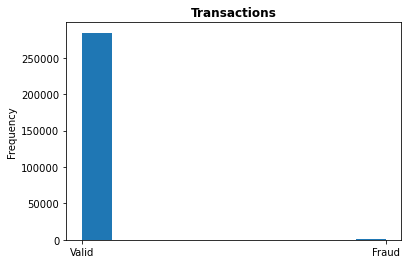

Valid frequency    284315 :    99.83%
Fraud frequency    492    :    0.17%


In [5]:
# We are creating a list to use the labels "Valid" and "Fraud" instead of 0 and 1... 
# I know that using the pandas .hist() and .value_counts() would be a much simpler way of doing the same thing
# but it would show our results with the 0 and 1 label and I think that in this way is easier to the reader understand


classe = []
for x in Data["Class"].values:
    if x == 0:
        classe.append("Valid")
    if x == 1:
        classe.append("Fraud")

val_count = classe.count("Valid")
fraud_count = classe.count("Fraud")
total = len(classe)

plt.hist(classe)
plt.title("Transactions",fontweight="bold")
plt.ylabel("Frequency")
plt.show()

print(f"Valid frequency    {val_count} :    {round(val_count*100/total,2)}%")
print(f"Fraud frequency    {fraud_count}    :    {round(fraud_count*100/total,2)}%")

As have been said the fraud frequency is very rare, you can see this in the above histrogram...

//Now we will divide our data set in two parts to see if we can gain any insight about then, the first one being about the valid transactions e the other one about the fraud transactions.// 

Now we will plot the histogram of the "Amount" column to the valids transactions and fraud transactions to see if there is any difference in behavior.

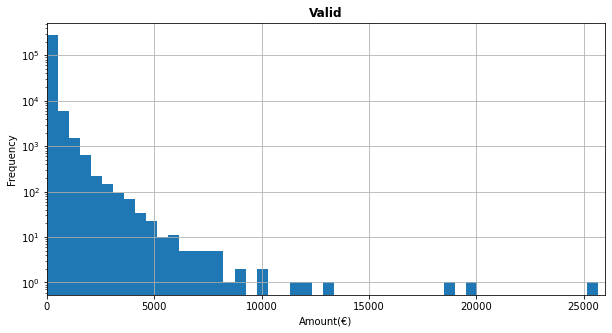

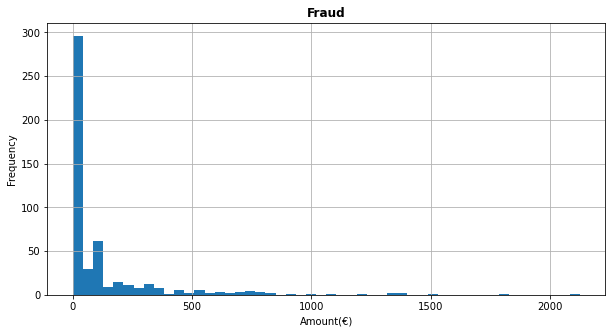

In [6]:
# Valid Transactions

plt.figure(figsize=(10,5))
Data.loc[Data["Class"] == 0]["Amount"].hist(bins=50)
plt.title("Valid",fontweight="bold")
plt.ylabel("Frequency")
plt.xlabel("Amount(€)")
plt.xlim((0,26000))
plt.yscale("log")

# Fraud Transaction

plt.figure(figsize=(10,5))
Data.loc[Data["Class"] == 1]["Amount"].hist(bins=50)
plt.title("Fraud",fontweight="bold")
plt.ylabel("Frequency")
plt.xlabel("Amount(€)")


plt.show()

In [7]:
print("\033[1mAmount spent in valid transactions")
Data.loc[Data["Class"] == 0]["Amount"].describe()

Amount spent in valid transactions


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [8]:
print("\033[1mAmount spent in fraud transactions")
Data.loc[Data["Class"] == 1]["Amount"].describe()

Amount spent in fraud transactions


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

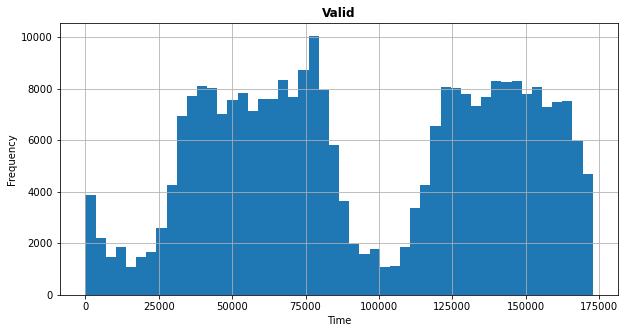

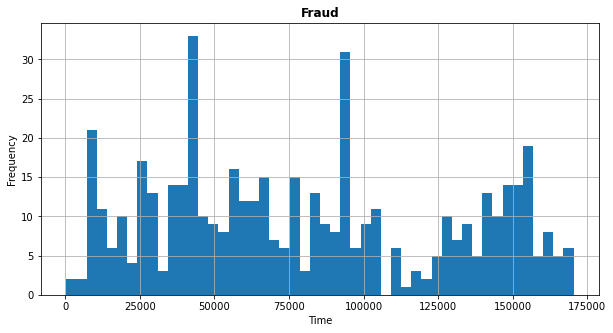

In [9]:
# Valid Transactions

plt.figure(figsize=(10,5))
Data.loc[Data["Class"] == 0]["Time"].hist(bins=50)
plt.title("Valid",fontweight="bold")
plt.ylabel("Frequency")
plt.xlabel("Time")

#lt.yscale("log")

# Fraud Transaction

plt.figure(figsize=(10,5))
Data.loc[Data["Class"] == 1]["Time"].hist(bins=50)
plt.title("Fraud",fontweight="bold")
plt.ylabel("Frequency")
plt.xlabel("Time")


plt.show()

#frequency = Data.loc[Data["Class"] == 0]["Time"].value_counts().sort_index(ascending=False).plot(kind="bar")
#time = Data.loc[Data["Class"] == 0]["Time"].values

frequency = Data.loc[Data["Class"] == 0]["Time"].values
time = Data.loc[Data["Class"] == 0]["Time"].values

plt.scatter(time,frequency)

# Scaling and Splitting the data

 First of all, its important to remmember that our frauds are extremely rare events, so in order to have a better model we should first create a more "balanced" dataset (for more information on that see https://www.youtube.com/watch?v=rHSpab1Wi9k at minute 14:35).

Our approach here is to create a dataframe that is 50% composed by frauds and 50% by valid transactions, and it contains all the fraud transactions of the original dataset. After that we must split 80% of this new dataframe to be our "train set" and merge the left 20% with the original dataframe to be our "test set". By doing that we can have a more realistic test set (almost every transaction will be non-fraudulent).

In [10]:
# We first shuffle the data before creating the subsample

Data = Data.sample(frac=1) #Return a random sample of items from an axis of object.

##

fraud_df = Data.loc[Data["Class"] == 1]
non_fraud_df = Data.loc[Data["Class"] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
98136,66535.0,1.200111,-0.900132,1.024904,-0.710115,-1.443730,-0.054955,-1.177034,0.219435,-0.619349,...,0.492777,1.269913,-0.089149,0.258421,0.269328,-0.052227,0.040756,0.020069,49.99,0
203328,134769.0,-0.967767,2.098019,-5.222929,6.514573,-4.187674,2.114178,0.948701,-2.448427,-3.203666,...,-0.843268,0.796739,1.314312,-0.352887,-1.770706,0.098133,0.956769,0.162777,925.31,1
270295,164008.0,-0.019137,0.452873,1.269691,-0.561533,0.175030,-0.082885,0.048134,0.041726,0.413675,...,0.326385,1.149822,-0.024927,-0.411565,-1.443505,0.089942,0.113792,0.058784,8.37,0
191544,129308.0,0.054682,1.856500,-4.075451,4.100098,-0.800931,-0.292502,-2.317431,1.189747,-0.786238,...,0.618248,0.800932,0.130016,0.288946,-0.366658,0.030307,0.431182,0.110698,80.90,1
41943,40892.0,-2.140511,4.104871,-8.996859,4.028391,-5.131359,-4.153568,-9.360095,1.922075,-4.026180,...,1.854267,-0.165534,-0.339939,0.296314,1.364225,-0.518996,2.352333,1.130625,0.76,1


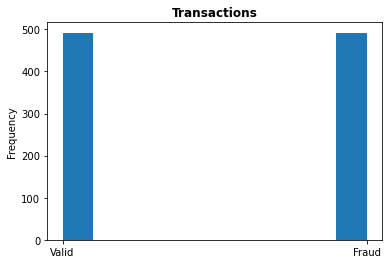

Valid frequency    492 :    50.0%
Fraud frequency    492 :    50.0%


In [11]:
# Using the same code as above XDDD


# We are creating a list to use the labels "Valid" and "Fraud" instead of 0 and 1... 
# I know that using the pandas .hist() and .value_counts() would be a much simpler way of doing the same thing
# but it would show our results with the 0 and 1 label and I think that in this way is easier to the reader understand


classe = []
for x in new_df["Class"].values:
    if x == 0:
        classe.append("Valid")
    if x == 1:
        classe.append("Fraud")

val_count = classe.count("Valid")
fraud_count = classe.count("Fraud")
total = len(classe)

plt.hist(classe)
plt.title("Transactions",fontweight="bold")
plt.ylabel("Frequency")
plt.show()

print(f"Valid frequency    {val_count} :    {round(val_count*100/total,2)}%")
print(f"Fraud frequency    {fraud_count} :    {round(fraud_count*100/total,2)}%")

In [12]:
# tem que criar o train e o test set, passar o transform apenas no set de treino

#Using the stratifiedshufflesplit 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

#Separing the predictions and labels, since we don´t necessarily want to apply the same transformations on then

X = new_df.drop('Class', axis=1)
y = new_df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    #print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

In [13]:
train_set = original_Xtrain
train_set_labels = original_ytrain

In [14]:
# Now we wanna check if the valid and and fraud fraction still the same in our trainning set
# The "Total" printed represent the proportion of the trainning set in compared with the raw data

prop_ftrain_set =  len(original_ytrain.loc[original_ytrain.values == 1])*100/len(original_ytrain)
prop_vtrain_set =  len(original_ytrain.loc[original_ytrain.values == 0])*100/len(original_ytrain)


print(f"Frauds = {prop_ftrain_set}%\nValids = {prop_vtrain_set}%\nTotal = {round(len(original_ytrain)*100/total,2)}%")

Frauds = 50.0%
Valids = 50.0%
Total = 80.08%


As you can see above we mantained the same distribution in our trainning set, now we need to merge the 20% remainning data into our previously data set.

*** Is it the best way to create a test set or should we just maintaing that 20% 50/50 split test set? ***

In [15]:
# First we have to drop all the values of the "new_df" so that we don't have duplicated values
Data = Data.drop(new_df.index)
    
# Now we put the Xtest and Ytest togheter
original_Xtest["Class"] = original_ytest.values
original_Xtest

# And then we concat the two df
Test_df = pd.concat([Data, original_Xtest])


# It is popping an error "Try using .loc[row_indexer,col_indexer] = value instead" but our code is working as espected, I do know what does that means

c:\users\lorentz\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
Y_test = Test_df["Class"].copy()
Test_df.drop(["Class"], axis=1, inplace=True)

We should now scale the "Amount" and "Time" values so that it matches the rest of the dataset

*ps: I'm not sure if we should use StandardScaler or RobustScaler, I'll use the RobustScaler method because I think that for this quantities "Amount" and "Time" our "outliers" (for example the £25k transaction) could be a problem (because in our entire dataset we just have one transaction greater than £25k, so I fear that if we have a fraud in that order of magnitude our model classifies it as a valid transaction); so we are using the RobustScaler to reduce the effect of outliers*

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler


transformer = RobustScaler()# We don't really need a pipeline because we are applying just that transformation 

####

scaled_amount = transformer.fit_transform(train_set["Amount"].values.reshape(-1,1))
scaled_time = transformer.fit_transform(train_set["Time"].values.reshape(-1,1))

In [19]:
# Now we drop the original values and introduce the scaled ones

train_set.drop(["Amount","Time"], axis = 1, inplace=True)

train_set.insert(0, 'Amount_Scl', scaled_amount)
train_set.insert(1, 'Time_Scl', scaled_time)

C:\Users\Lorentz\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
train_set.head()

,Amount_Scl,Time_Scl,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
98136,0.328973,-0.147315,1.200111,-0.900132,1.024904,-0.710115,-1.443730,-0.054955,-1.177034,0.219435,...,0.067374,0.114908,0.492777,1.269913,-0.089149,0.258421,0.269328,-0.052227,0.040756,0.020069
203328,9.171482,0.643643,-0.967767,2.098019,-5.222929,6.514573,-4.187674,2.114178,0.948701,-2.448427,...,0.952141,1.147204,-0.843268,0.796739,1.314312,-0.352887,-1.770706,0.098133,0.956769,0.162777
270295,-0.091474,0.982577,-0.019137,0.452873,1.269691,-0.561533,0.175030,-0.082885,0.048134,0.041726,...,-0.724789,0.010894,0.326385,1.149822,-0.024927,-0.411565,-1.443505,0.089942,0.113792,0.058784
191544,0.641226,0.580340,0.054682,1.856500,-4.075451,4.100098,-0.800931,-0.292502,-2.317431,1.189747,...,2.351151,0.509559,0.618248,0.800932,0.130016,0.288946,-0.366658,0.030307,0.431182,0.110698
41943,-0.168350,-0.444565,-2.140511,4.104871,-8.996859,4.028391,-5.131359,-4.153568,-9.360095,1.922075,...,2.995111,1.725578,1.854267,-0.165534,-0.339939,0.296314,1.364225,-0.518996,2.352333,1.130625


In [21]:
Data_prepared,Data_labels = train_set, train_set_labels

# Select and Train a Model

In [22]:
# importing all the models we wanna test

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import  LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

We should now create a function to fit and evaluate all models, but how should we evaluate the models? Because in the train set we have a 50/50 distribution and in the test set it is almost 99/1.

In [23]:
# Function that runs an algorithm and returns it's precision, recall and F1 score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

def fit_model(algo, X_train, Y_train, cv):
    
    # Making predctions using the cross_val_predict
    y_train_pred = cross_val_predict(algo, X_train, Y_train, cv=cv)
    
    # Evaluate precision
    precision = precision_score(Y_train, y_train_pred) 
    
    # Evaluate recall
    recall =  recall_score(Y_train, y_train_pred)
    
    # Evaluate the F1 score
    F1_score = f1_score(Y_train, y_train_pred)
    
    return round( (100*precision),2), round( (100*recall),2), round( (100*F1_score),2)

In [24]:
# Fitting all models

# K_nearest neighbors

KNN_precision, KNN_recall, KNN_f1 = fit_model(KNeighborsClassifier(), 
                   Data_prepared, 
                   Data_labels, 
                   10)
# Logistic Regression

LR_precision, LR_recall, LR_f1 = fit_model(LogisticRegression(), 
                   Data_prepared, 
                   Data_labels, 
                   10)
                        
# Support Vector machine

SVM_precision, SVM_recall, SVM_f1 = fit_model(svm.SVC(), 
                   Data_prepared, 
                   Data_labels, 
                   10)

# Gaussian Naive Bayes

GNB_precision, GNB_recall, GNB_f1 = fit_model(GaussianNB(), 
                   Data_prepared, 
                   Data_labels, 
                   10)

# Stochastic Gradient Descent

SGD_precision, SGD_recall, SGD_f1 = fit_model(SGDClassifier(), 
                   Data_prepared, 
                   Data_labels, 
                   10)

# Decision Tree Classifier

DTC_precision, DTC_recall, DTC_f1 = fit_model(DecisionTreeClassifier(), 
                   Data_prepared, 
                   Data_labels, 
                   10)

# Gradient Boost Trees

GBT_precision, GBT_recall, GBT_f1 = fit_model(GradientBoostingClassifier(), 
                   Data_prepared, 
                   Data_labels, 
                   10)

# Random Forest Regressor

from sklearn.ensemble import RandomForestClassifier
RFR_precision, RFR_recall, RFR_f1 = fit_model(RandomForestClassifier(), 
                   Data_prepared, 
                   Data_labels, 
                   10)



In [25]:
precision_scores = [KNN_precision, LR_precision, SVM_precision, GNB_precision, SGD_precision, DTC_precision, GBT_precision]
recall_scores = [KNN_recall, LR_recall, SVM_recall, GNB_recall, SGD_recall, DTC_recall, GBT_recall]
f1_scores = [KNN_f1, LR_f1, SVM_f1, GNB_f1, SGD_f1, DTC_f1, GBT_f1]


# Scores data frame

score_df = pd.DataFrame({
    'Model': ['K-NearestNeighbors','Logistic Regression',
              'Support Vector Machines','Gaussian Naive Bayes',
              'Stochastic Gradient Descent','Decision Tree Classifier',
              'Gradient Boost Trees'],
    
    'F1 Score':
    f1_scores,
    
    'Precision Score':
    precision_scores,
    
    'Recall Score':
    recall_scores
    

})

print('---Harmoic Mean Scores---')
score_df.sort_values(by='F1 Score', ascending=False)

---Harmoic Mean Scores---


,Model,F1 Score,Precision Score,Recall Score
6,Gradient Boost Trees,95.05,97.59,92.64
1,Logistic Regression,94.68,96.82,92.64
0,K-NearestNeighbors,94.21,97.81,90.86
2,Support Vector Machines,93.76,98.33,89.59
4,Stochastic Gradient Descent,93.44,94.78,92.13
3,Gaussian Naive Bayes,92.43,96.94,88.32
5,Decision Tree Classifier,91.84,90.82,92.89


In [26]:
# Transforming the amount and time features in the test set so that we can use our models correctly


scaled_amount_test = transformer.transform(Test_df["Amount"].values.reshape(-1,1))
scaled_time_test = transformer.transform(Test_df["Time"].values.reshape(-1,1))


# Now we drop the original values and introduce the scaled ones

Test_df.drop(["Amount","Time"], axis = 1, inplace=True)

Test_df.insert(0, 'Amount_Scl', scaled_amount_test)
Test_df.insert(1, 'Time_Scl', scaled_time_test)

In [31]:
def _model(algo, X_train, Y_train,X_test,Y_test, cv):
    
    
    algo_fit =  algo.fit(X_train, Y_train)
    
    # Making predctions using the cross_val_predict
    y_train_pred = cross_val_predict(algo, X_train, Y_train, cv=cv)
    
    # Evaluate precision
    precision_train = precision_score(Y_train, y_train_pred) 
    
    # Evaluate recall
    recall_train =  recall_score(Y_train, y_train_pred)
    
    # Evaluate the F1 score
    F1_score_train = f1_score(Y_train, y_train_pred)
    
    
    # Now for the test set
    
    y_test_predict = cross_val_predict(algo, X_test, Y_test, cv=cv)
    
    # Evaluate precision
    precision_test = precision_score(Y_test, y_test_predict) 
    
    # Evaluate recall
    recall_test =  recall_score(Y_test, y_test_predict)
    
    # Evaluate the F1 score
    F1_score_test = f1_score(Y_test, y_test_predict)
    
    
    
    return round( (100*precision_train),2), round( (100*recall_train),2), round( (100*F1_score_train),2),round( (100*precision_test),2), round( (100*recall_test),2), round( (100*F1_score_test),2)


# K_nearest neighbors

KNN_train_precision, KNN_train_recall, KNN_train_f1,KNN_test_precision, KNN_test_recall, KNN_test_f1 = _model(
    KNeighborsClassifier(), 
    Data_prepared, 
    Data_labels,
    Test_df,
    Y_test,
    10)

In [32]:
KNN_test_precision, KNN_test_recall, KNN_test_f1

(82.14, 46.94, 59.74)

In [33]:
KNN_train_precision, KNN_train_recall, KNN_train_f1

(97.81, 90.86, 94.21)

In [39]:
KNN = svm.SVC()
KNN.fit(Data_prepared, Data_labels)
final_predictions = KNN.predict(Test_df)

precision_test = precision_score(Y_test, final_predictions) 
    
# Evaluate recall
recall_test =  recall_score(Y_test, final_predictions)
    
# Evaluate the F1 score
F1_score_test = f1_score(Y_test, final_predictions)




    
round( (100*precision_test),2), round( (100*recall_test),2), round( (100*F1_score_test),2)

(1.86, 80.61, 3.64)

In [35]:
round( (100*precision_test),2), round( (100*recall_test),2), round( (100*F1_score_test),2)

(1.93, 85.71, 3.77)